## MLRATE
- https://towardsdatascience.com/variance-reduction-on-steroids-introducing-mlrate-be328cd71a03/

## Data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
import statsmodels.api as sm

rng = np.random.default_rng(seed=42)
n = 10_000

pre_experiment = rng.normal(loc=0, scale=1.5, size=n)
control = pre_experiment + rng.normal(loc=0, scale=1.5, size=n)
treatment = pre_experiment + rng.normal(loc=0.75, scale=1.5, size=n)

df = pd.DataFrame({
    'pre_experiment': np.concatenate([pre_experiment, pre_experiment]),
    'experiment': np.concatenate([control, treatment]),
    'group': [0]*n + [1]*n # ['control']*n + ['treatment']*n
})

## T-Test and OLS

In [3]:
t_stat, p_value = ttest_ind(treatment, control)
print(f"T-test results:")
print(f"   p-value     : {p_value:.6f}")
print(f"   t-statistic : {t_stat:.4f}\n")

X = sm.add_constant(df['group'])
model = sm.OLS(df['experiment'], X).fit()
print(f"OLS results:")
print(f"  p-value     : {model.pvalues['group']:.6f}")
print(f"  t-statistic : {model.tvalues['group']:.4f}")
print(f"  Coefficient : {model.params['group']:.4f}")
print(f"  Std Error   : {model.bse['group']:.4f}")

T-test results:
   p-value     : 0.000000
   t-statistic : 24.7077

OLS results:
  p-value     : 0.000000
  t-statistic : 24.7077
  Coefficient : 0.7411
  Std Error   : 0.0300


Fun fact: the coefficient of the regression can also be found through the difference in means between the treatment and control or by taking ${cov(x,y)}/{var(x)}$.

In [ ]:
print(f"Difference in means: {np.mean(treatment) - np.mean(control):.4f}")
print(f"cov(x,y) / var(x): {np.cov(df['experiment'], X['group'])[0, 1] / np.var(X['group']):.4f}")

Difference in means: 0.7411
cov(x,y) / var(x): 0.7411


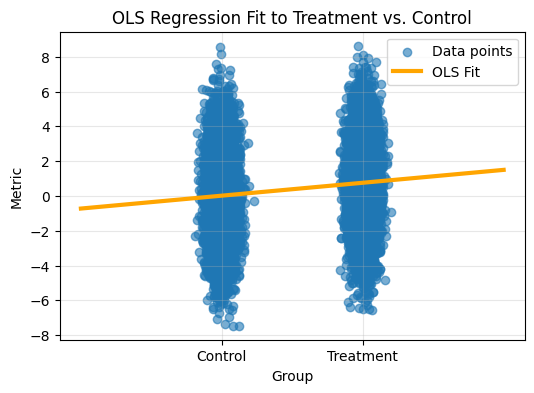

In [328]:
plt.figure(figsize=(6, 4))

# Scatter plot of data points
plt.scatter(df['group'] + rng.normal(scale=0.05, size=2*n),  # jitter for clarity
            df['experiment'],
            alpha=0.6,
            label='Data points')

# Regression line
group_vals = np.array([-1, 2])
predicted_vals = model.predict(sm.add_constant(group_vals))
plt.plot(group_vals, predicted_vals, color='orange', linewidth=3, label='OLS Fit')
plt.xticks([0, 1], ['Control', 'Treatment'])
plt.xlabel('Group')
plt.ylabel('Metric')
plt.title('OLS Regression Fit to Treatment vs. Control')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Difference-in-Difference
- https://www.publichealth.columbia.edu/research/population-health-methods/difference-difference-estimation

$$ \text{DiD estimate} = (\text{Treatment}_{post} - \text{Treatment}_{pre}) - (\text{Control}_{post} - \text{Control}_{pre}) $$
$$ Y = \beta_0 + \beta_1 * \text{Time} + \beta_2 * \text{Intervention} + \beta_3 * \text{Time} * \text{Intervention} + \beta_4 * \text{Covariates} + \epsilon $$

In [302]:
df_long = pd.DataFrame({
    'metric': np.concatenate([pre_experiment, control, pre_experiment, treatment]),
    'group': ['control']*n*2 + ['treatment']*n*2,
    'period': ['pre']*n + ['post']*n + ['pre']*n + ['post']*n
})

# Encode categorical variables
df_long['group_encoded'] = (df_long['group'] == 'treatment').astype(int)
df_long['period_encoded'] = (df_long['period'] == 'post').astype(int)

# Interaction term (group * period)
df_long['interaction'] = df_long['group_encoded'] * df_long['period_encoded']

# display(df_long)

# Fit DiD regression model
X_did = sm.add_constant(df_long[['group_encoded', 'period_encoded', 'interaction']])
model_did = sm.OLS(df_long['metric'], X_did).fit()

print(f"Difference-in-Difference (DiD) results:")
print(f"  DiD Coefficient : {model_did.params['interaction']:.4f}")
print(f"  Std Error       : {model_did.bse['interaction']:.4f}")
print(f"  t-statistic     : {model_did.tvalues['interaction']:.4f}")
print(f"  p-value         : {model_did.pvalues['interaction']:.6f}\n")

# Interpretation:
print("Interpretation:")
print(f"The DiD coefficient ({model_did.params['interaction']:.4f}) represents the estimated treatment effect,")
print(f"adjusting for pre-experiment differences and common trends over time.")


Difference-in-Difference (DiD) results:
  DiD Coefficient : 0.7411
  Std Error       : 0.0368
  t-statistic     : 20.1300
  p-value         : 0.000000

Interpretation:
The DiD coefficient (0.7411) represents the estimated treatment effect,
adjusting for pre-experiment differences and common trends over time.


The DiD coefficient is the same as just taking the mean differences. The benefit of the linear model is that we can do statistical inference (p-value / std error).

In [305]:
# Full equation: (treatment.mean() - control.mean()) - (pre_experiment.mean() - pre_experiment.mean())

# Simplifies to:
(treatment.mean() - control.mean())

0.7411025787993734

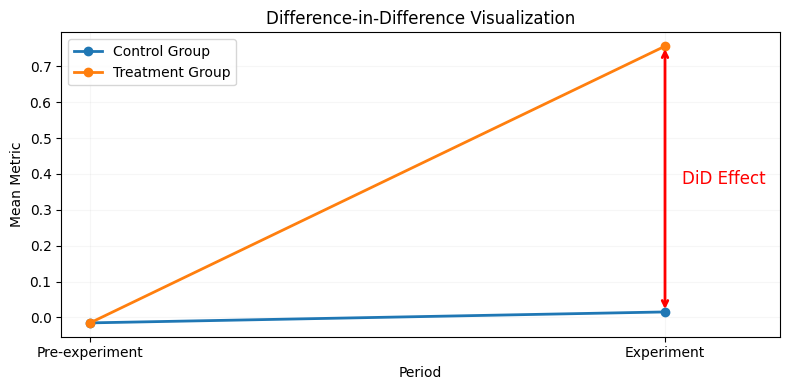

In [327]:
means = {
    'Pre-experiment': {
        'control': np.mean(pre_experiment),
        'treatment': np.mean(pre_experiment)  # identical by design in pre-period
    },
    'Experiment': {
        'control': np.mean(control),
        'treatment': np.mean(treatment)
    }
}

fig, ax = plt.subplots(figsize=(8, 4))

# Numeric positions for x-coordinates
x_coords = [0, 1]

# Plot Control and Treatment lines
ax.plot(x_coords,
        [means['Pre-experiment']['control'], means['Experiment']['control']],
        marker='o', label='Control Group', linestyle='-', linewidth=2)

ax.plot(x_coords,
        [means['Pre-experiment']['treatment'], means['Experiment']['treatment']],
        linestyle='-', marker='o', linewidth=2, label='Treatment Group')

# Annotate DiD effect
ax.annotate('', xy=(1, means['Experiment']['treatment']),
            xytext=(1, means['Experiment']['control']),
            arrowprops=dict(arrowstyle='<->', color='red', linewidth=2))

# Slightly offset text to the right (e.g., +0.03)
ax.text(1 + 0.03,
        (means['Experiment']['treatment'] + means['Experiment']['control']) / 2,
        'DiD Effect', va='center', ha='left', fontsize=12, color='red')

# Set custom x-ticks and labels
ax.set_xticks(x_coords)
ax.set_xticklabels(['Pre-experiment', 'Experiment'])
ax.set_xlim(x_coords[0]-0.05, x_coords[1]+0.2)
ax.set_xlabel('Period')
ax.set_ylabel('Mean Metric')
ax.set_title('Difference-in-Difference Visualization')
ax.legend()
ax.grid(alpha=0.1)
plt.tight_layout()
plt.show()

## CUPED
- https://matteocourthoud.github.io/post/cuped/
- https://medium.com/towards-data-science/how-to-double-a-b-testing-speed-with-cuped-f80460825a90


CUPED works by adjusting observed outcomes with pre-experiment covariates to reduce variance. The optimal covariate is often the same metric from the pre-experiment period.

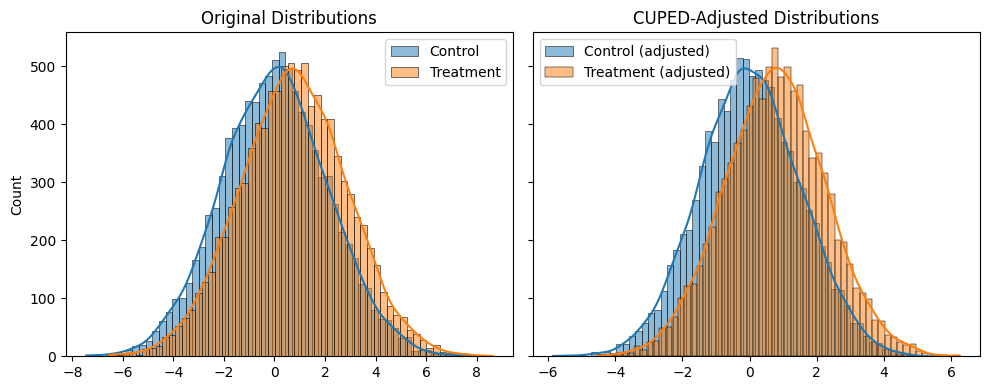

In [286]:
# Compute theta (optimal regression coefficient)
theta = np.cov(control, pre_experiment)[0, 1] / np.var(pre_experiment)

# Adjust metrics using CUPED
control_adjusted = control - theta * (pre_experiment - np.mean(pre_experiment))
treatment_adjusted = treatment - theta * (pre_experiment - np.mean(pre_experiment))

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

sns.histplot(control, label='Control', ax=axes[0], kde=True)
sns.histplot(treatment, label='Treatment', ax=axes[0], kde=True)
axes[0].legend()
axes[0].set_title("Original Distributions")

sns.histplot(control_adjusted, label='Control (adjusted)', ax=axes[1], kde=True)
sns.histplot(treatment_adjusted, label='Treatment (adjusted)', ax=axes[1], kde=True)
axes[1].legend()
axes[1].set_title("CUPED-Adjusted Distributions")

plt.tight_layout()
plt.show()

In [287]:
covariate_cols = ['pre_experiment']

# Fit linear regression model on combined data
model = LinearRegression()
model.fit(df[covariate_cols], df['experiment'])

# Adjusted observations
covariates_centered = df[covariate_cols] - df[covariate_cols].mean()
df['experiment_adjusted'] = df['experiment'] - covariates_centered @ model.coef_

# Check variance reduction
var_before = df.groupby('group')['experiment'].var()
var_after = df.groupby('group')['experiment_adjusted'].var()
variance_reduction = 1 - var_after.mean() / var_before.mean()

print(f"Variance reduction: {variance_reduction:.2%}")

# Perform adjusted t-test
control_adj = df[df.group == 0]['experiment_adjusted']
treatment_adj = df[df.group == 1]['experiment_adjusted']

t_stat, p_value = ttest_ind(treatment_adj, control_adj)
print(f"\nAdjusted T-test Results:")
print(f"   p-value     : {p_value:.6f}")
print(f"   t-statistic : {t_stat:.4f}\n")

Variance reduction: 49.68%

Adjusted T-test Results:
   p-value     : 0.000000
   t-statistic : 34.8318



Multiple covariates

In [252]:
df['browser_type'] = rng.choice(['Chrome', 'Firefox'], size=n*2)
df = pd.get_dummies(df, columns=['browser_type'])

# Define covariates
covariate_cols = ['pre_experiment', 'browser_type_Chrome', 'browser_type_Firefox']

# Fit linear regression model on combined data
model = LinearRegression()
model.fit(df[covariate_cols], df['experiment'])

# Compute adjusted metric
covariates_centered = df[covariate_cols] - df[covariate_cols].mean()
df['experiment_adjusted'] = df['experiment'] - covariates_centered @ model.coef_

# Check variance reduction
var_before = df.groupby('group')['experiment'].var()
var_after = df.groupby('group')['experiment_adjusted'].var()
variance_reduction = 1 - var_after.mean() / var_before.mean()

print("Variance reduction using multiple covariates:", round(variance_reduction * 100, 2), "%")

# Perform adjusted t-test
control_adj = df[df.group == 0]['experiment_adjusted']
treatment_adj = df[df.group == 1]['experiment_adjusted']

t_stat, p_value = ttest_ind(treatment_adj, control_adj)
print(f"\nAdjusted T-test Results:")
print(f"   p-value     : {p_value:.6f}")
print(f"   t-statistic : {t_stat:.4f}\n")

Variance reduction using multiple covariates: 49.68 %

Adjusted T-test Results:
   p-value     : 0.000000
   t-statistic : 34.8314

